In [1]:
import pandas as pd
import sqlite3

# Connecting to SQLite database
conn = sqlite3.connect('sales.db')

# Load data into a DataFrame
query = "SELECT CustomerID, CustomerName, SUM(Sales) AS TotalSpent FROM sales GROUP BY CustomerID, CustomerName;"
df = pd.read_sql(query, conn)

# Close connection
#conn.close()
print(df.columns)


Index(['CustomerID', 'CustomerName', 'TotalSpent'], dtype='object')


In [2]:
import pandas as pd
import datetime
import sqlite3

# Simulate present date
today = datetime.datetime(2024, 2, 25)

# Connect to SQLite database and load the data
conn = sqlite3.connect("sales.db")
query = """
SELECT OrderDate, Sales, CustomerID, OrderID
FROM sales
"""
df = pd.read_sql(query, conn)

# Convert OrderDate to datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'], dayfirst = True)

# Calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'OrderDate': lambda x: (today - x.max()).days,  # Recency: days since last purchase
    'OrderID': 'count',  # Frequency: number of orders
    'Sales': 'sum'  # Monetary: total sales
}).reset_index()

# Rename the columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Display the RFM dataframe
print(rfm.head())

  CustomerID  Recency  Frequency  Monetary
0   AA-10315     2067         11  5563.560
1   AA-10375     1902         15  1056.390
2   AA-10480     2142         12  1790.512
3   AA-10645     1938         18  5086.935
4   AB-10015     2298          6   886.156


In [3]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Apply K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print(rfm.head())


  CustomerID  Recency  Frequency  Monetary  Cluster
0   AA-10315     2067         11  5563.560        0
1   AA-10375     1902         15  1056.390        0
2   AA-10480     2142         12  1790.512        1
3   AA-10645     1938         18  5086.935        0
4   AB-10015     2298          6   886.156        3


In [4]:
import datetime as dt

# Define the snapshot date (the latest purchase date in the dataset)
snapshot_date = df['OrderDate'].max() + dt.timedelta(days=1)

# Calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'OrderDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'OrderID': 'count',  # Frequency
    'Sales': 'sum'  # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Assign RFM scores (1-5) using quantiles
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Create RFM segment by combining scores
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

print(rfm.head(5))


            Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Segment
CustomerID                                                                  
AA-10315        185         11  5563.560       2       3       5         235
AA-10375         20         15  1056.390       5       4       2         542
AA-10480        260         12  1790.512       1       3       3         133
AA-10645         56         18  5086.935       3       5       5         355
AB-10015        416          6   886.156       1       1       1         111


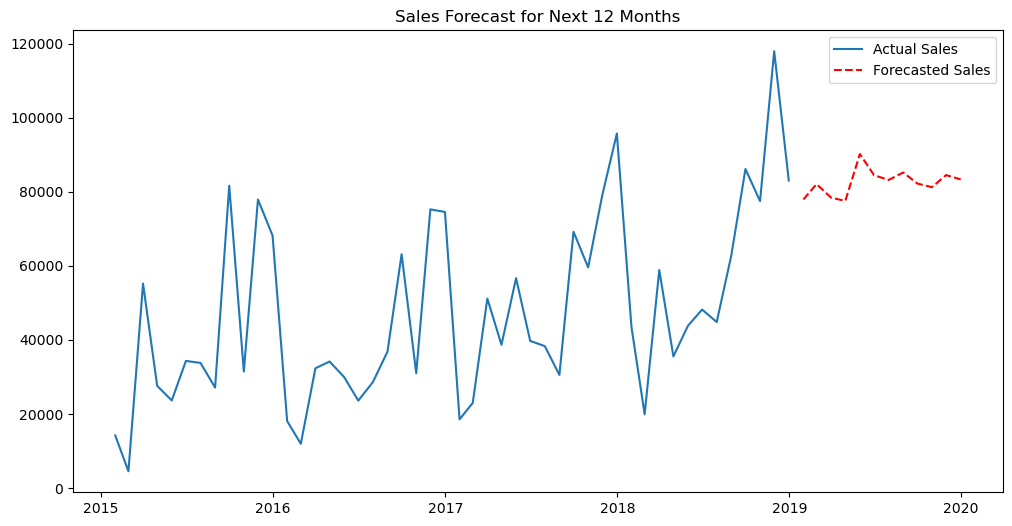

In [5]:

import matplotlib.pyplot as plt
import statsmodels.api as sm

# Aggregate sales by month
df_monthly = df.groupby(pd.Grouper(key='OrderDate', freq='M')).sum()['Sales']

# Fit ARIMA model
model = sm.tsa.ARIMA(df_monthly, order=(5,1,0))  # (p,d,q) parameters
model_fit = model.fit()

# Forecast next 12 months
forecast = model_fit.forecast(steps=12)

# Plot results
plt.figure(figsize=(12,6))
plt.plot(df_monthly, label='Actual Sales')
plt.plot(forecast, label='Forecasted Sales', linestyle='dashed', color='red')
plt.legend()
plt.title("Sales Forecast for Next 12 Months")
plt.show()
